# Задание
1. С помощью OpenCV и веб-камеры получить изображение документа на листе A4
2. Перевести изображение в серошкальный формат
3. Определить координаты угловых точек документа с помощью интерактивный утилиты matplotlib (см. семинар 1)
4. Выполнить преобразование перспективы так, чтобы плоскость документа была выровнена (эффект сканирования)
5. Провести адаптивную эквализацию гистограммы
6. Выделить на изображении все границы
7. Получить маску по границам
8. Применить маску к изображению, полученному на этапе 5.

In [1]:
# Воспользуемся внешним бэкендом для построения изображений
import matplotlib
import numpy as np
from PIL import Image
import scipy.ndimage as sp
import cv2
from matplotlib import pyplot as plt


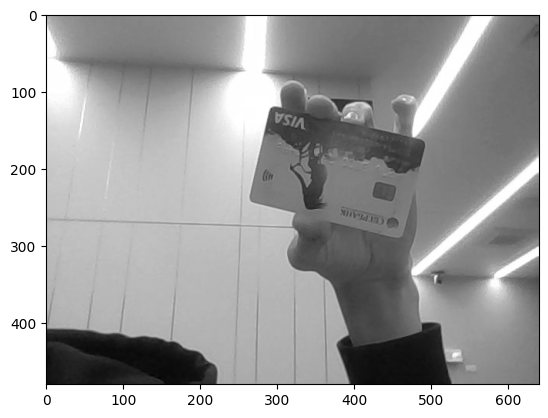

In [2]:
# 1. Считать изображение с камеры
cap = cv2.VideoCapture(0)
ret, frame = cap.read()
cap.release()


gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, cmap='gray');


In [3]:
matplotlib.use('TkAgg')
%matplotlib qt
# the interactive plot

In [4]:
im = gray
plt.imshow(im, cmap='gray')
print('Please click 4 points')
coord = plt.ginput(4)
print('you clicked:', coord)
plt.show()

Please click 4 points
you clicked: [(263.6558441558442, 238.98051948051943), (293.52597402597405, 120.79870129870119), (490.92857142857156, 167.551948051948), (457.1623376623378, 288.3311688311688)]


In [5]:
# Возврат к встроенному отображению
%matplotlib inline

In [6]:
coordinates = [(int(x), int(y)) for x, y in coord]
print(coordinates)
width_ratio = coordinates[1][0]-coordinates[0][0]
height_ratio = coordinates[2][1]-coordinates[1][1]

[(263, 238), (293, 120), (490, 167), (457, 288)]


In [52]:
def rotated_rectangle_dimensions(points):
    # Преобразование массива точек в нужный формат для функции cv2.minAreaRect()
    rect_points = np.array(points, dtype=np.float32)

    # Нахождение ограничивающего прямоугольника
    rotated_rect = cv2.minAreaRect(rect_points)

    # Получение размеров прямоугольника (ширины и высоты)
    width = int(rotated_rect[1][0])
    height = int(rotated_rect[1][1])

    return width, height


width, height = rotated_rectangle_dimensions(coordinates[:3])

print(f"Ширина: {width} пикселей")
print(f"Высота: {height} пикселей")

Ширина: 103 пикселей
Высота: 237 пикселей


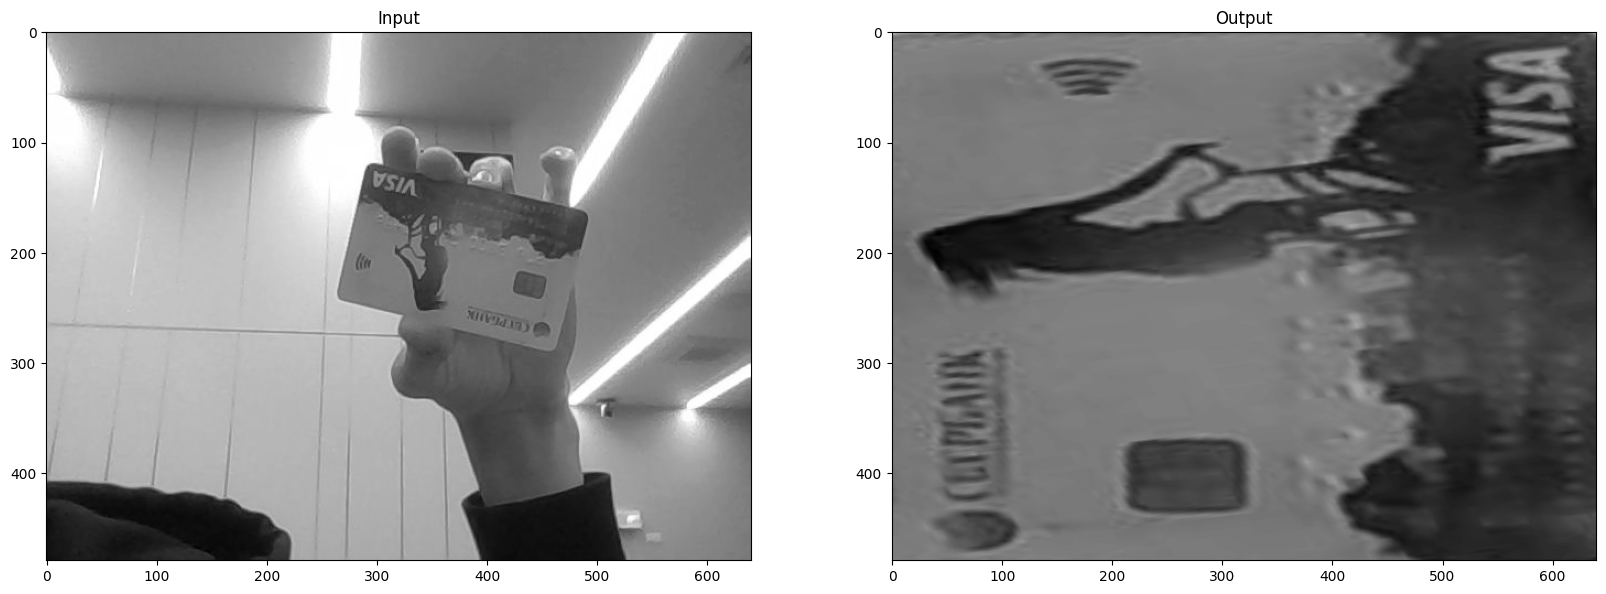

In [106]:
rows,cols = im.shape

pts1 = np.float32(coordinates)
pts2 = np.float32([[0,0],[im.shape[1], 0],[im.shape[1], im.shape[0]],[0, im.shape[0]]])

M = cv2.getPerspectiveTransform(pts1,pts2)
dst = cv2.warpPerspective(im,M,(im.shape[1],im.shape[0]))

plt.figure(figsize=(20, 20))
plt.subplot(121),plt.imshow(im, cmap='gray'),plt.title('Input')
plt.subplot(122),plt.imshow(dst, cmap='gray'),plt.title('Output')
plt.show()

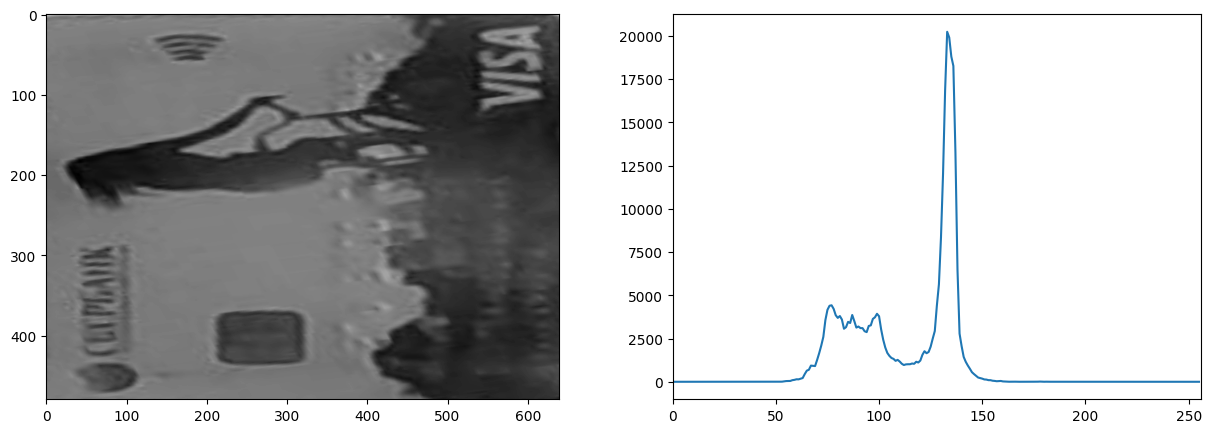

In [107]:

hist_full = cv2.calcHist([dst],[0],None,[256],[0,256])

plt.figure(figsize=(15, 5))
plt.subplot(121), plt.imshow(dst, 'gray')
plt.subplot(122), plt.plot(hist_full),plt.xlim([0,256])
plt.show()

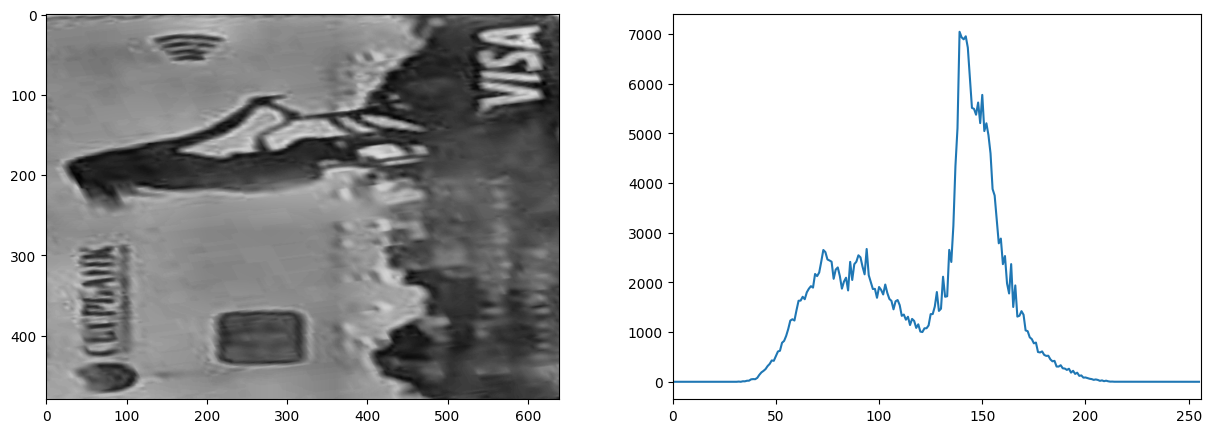

In [109]:
# Создание объекта адаптивной эквализации гистограммы
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))

# Применение адаптивной эквализации гистограммы
adaptive_eq = clahe.apply(dst)
hist_eq_scene = cv2.calcHist([adaptive_eq],[0],None,[256],[0,256])

plt.figure(figsize=(15, 5))
plt.subplot(121), plt.imshow(adaptive_eq, 'gray')
plt.subplot(122), plt.plot(hist_eq_scene),plt.xlim([0,256])
plt.show()
dst = adaptive_eq.copy()

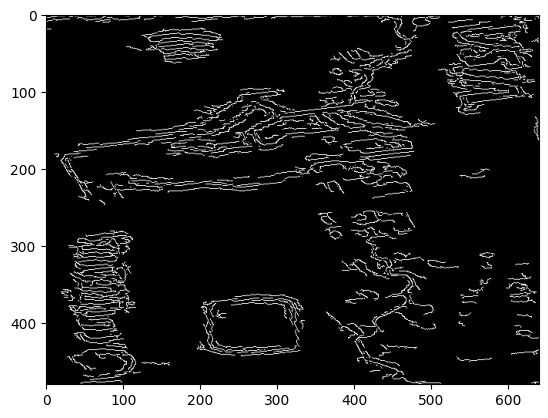

In [110]:
canny = cv2.Canny(adaptive_eq, 30, 80)
plt.imshow(canny, cmap="gray")
plt.show()

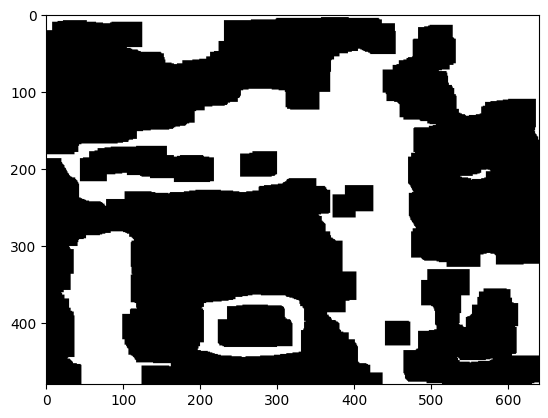

In [111]:
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 30))
closed = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel)
plt.imshow(closed, cmap="gray")
plt.show()

6


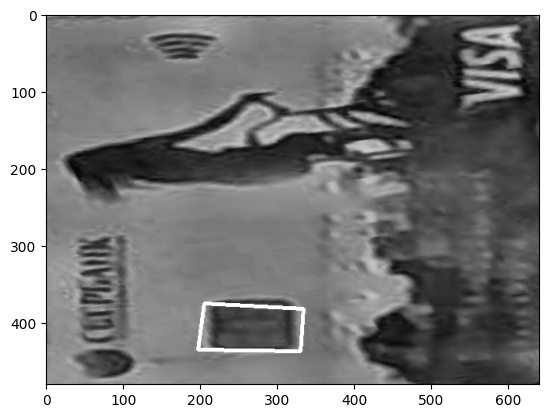

In [118]:
contours = cv2.findContours(closed.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
print(len(contours))
dst_temp = dst.copy()
for cont in contours:
        #сглаживание и определение количества углов
        sm = cv2.arcLength(cont, True)
        apd = cv2.approxPolyDP(cont, 0.05*sm, True)
        #выделение контуров
        if len(apd) == 4:
                cv2.drawContours(dst_temp, [apd], -1, (255,255,0), 3)
cv2.imwrite('result.jpg', dst)
plt.imshow(dst_temp, cmap='gray')
plt.show()

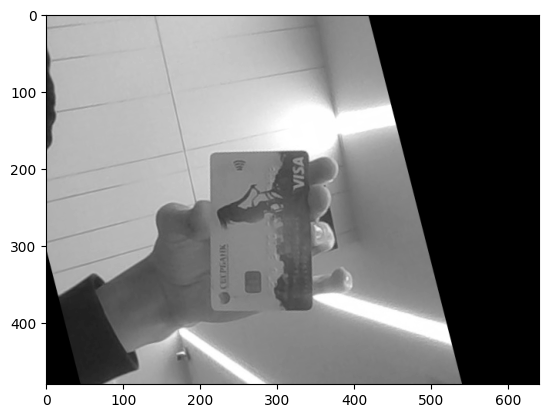

In [121]:
point1, point2 = coordinates[0], coordinates[1]

# Определение угла поворота
angle = np.arctan2(point2[1] - point1[1], point2[0] - point1[0]) * 180 / np.pi

# Определение центра поворота (среднее положение между точками)
center = ((point1[0] + point2[0]) / 2, (point1[1] + point2[1]) / 2)

# Вычисление матрицы преобразования поворота
rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1)

# Применение поворота к изображению
rotated_im = cv2.warpAffine(im, rotation_matrix, (im.shape[1], im.shape[0]))

plt.imshow(rotated_im, cmap='gray');

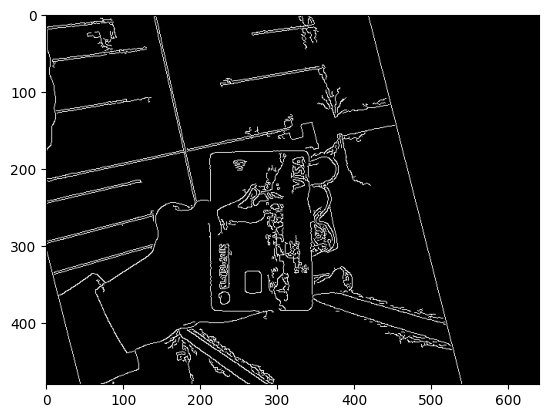

In [127]:
canny = cv2.Canny(rotated_im, 0, 100)
plt.imshow(canny, cmap="gray")
plt.show()

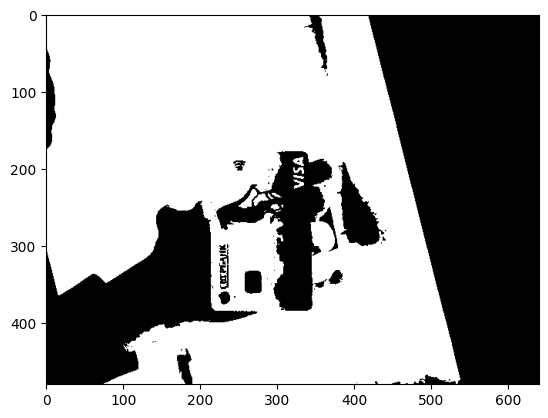

In [165]:
# Применение фильтрации или бинаризации (пример)
_, thresh = cv2.threshold(rotated_im, 120, 255, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap="gray")
plt.show()


1


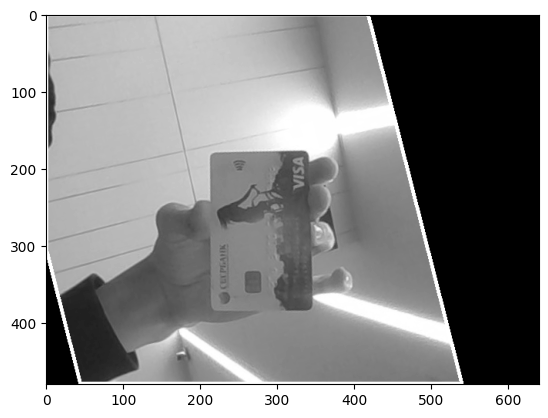

In [167]:
contours = cv2.findContours(rotated_im.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[0]
print(len(contours))
dst_temp = rotated_im.copy()
for cont in contours[:]:
        #сглаживание и определение количества углов
        sm = cv2.arcLength(cont, True)
        apd = cv2.approxPolyDP(cont, 0.05*sm, True)
        #выделение контуров
        #if len(apd) == 4:
        cv2.drawContours(dst_temp, [cont], -1, (255,255,0), 3)

plt.imshow(dst_temp, cmap='gray')
plt.show()